# Import dependencies

In [1]:
!pip install --upgrade imutils 
!pip install pygobject
!pip install playsound

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7035 sha256=e3fc0b8a149b81a66b0afc08b787843b77604badbe10e41bedd1795286acc540
  Stored in directory: /root/.cache/pip/wheels/ba/f8/bb/ea57c0146b664dca3a0ada4199b0ecb5f9dfcb7b7e22b65ba2
Successfully built playsound


In [ ]:
!wget https://github.com/Practical-CV/Facial-Landmarks-Detection-with-DLIB/blob/master/facial_landmarks.py
!wget -nd https://github.com/JeffTrain/selfie/raw/master/shape_predictor_68_face_landmarks.dat

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [2]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
from scipy.spatial import distance as dist
from imutils.video import VideoStream
from imutils import face_utils
from threading import Thread
from numpy import expand_dims
from PIL import Image, ImageOps
from collections import namedtuple
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
import playsound
import argparse
import imutils
import dlib
import pandas as pd
import tensorflow as tf
%matplotlib inline

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


# Helper Functions
Here are a few helper functions defined that will be used to easily convert between different image types within our later steps.

In [3]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# Face Detection

## Cloning and Setting Up Darknet for YOLOv4
We will be using the famous AlexeyAB's darknet repository in this tutorial to perform YOLOv4 detections.

In [4]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15424, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 15424 (delta 0), reused 0 (delta 0), pack-reused 15423
Receiving objects: 100% (15424/15424), 14.05 MiB | 17.96 MiB/s, done.
Resolving deltas: 100% (10364/10364), done.


In [5]:
# change makefile to have GPU, OPENCV and LIBSO enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [6]:
# make darknet (builds darknet so that you can then use the darknet.py file and have its dependencies)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old ==

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!cp -av '/content/drive/MyDrive/TFG/yolov3/yoloface/cfg/face.names' '/content/darknet/cfg'
!cp -av '/content/drive/MyDrive/TFG/yolov3/yoloface/cfg/yolov3-face.cfg' '/content/darknet/cfg'
!cp -av '/content/drive/MyDrive/TFG/yolov3/yoloface/model-weights/yolov3-wider_16000.weights' '/content/darknet'
!cp -av '/content/drive/MyDrive/TFG/yolov3/yoloface/requirements.txt' '/content/darknet'

'/content/drive/MyDrive/TFG/yolov3/yoloface/cfg/face.names' -> '/content/darknet/cfg/face.names'
'/content/drive/MyDrive/TFG/yolov3/yoloface/cfg/yolov3-face.cfg' -> '/content/darknet/cfg/yolov3-face.cfg'
'/content/drive/MyDrive/TFG/yolov3/yoloface/model-weights/yolov3-wider_16000.weights' -> '/content/darknet/yolov3-wider_16000.weights'
'/content/drive/MyDrive/TFG/yolov3/yoloface/requirements.txt' -> '/content/darknet/requirements.txt'


In [9]:
!sed -i 's/80/1/g' /content/darknet/cfg/coco.data
!sed -i 's+data/coco.names+cfg/face.names+g' /content/darknet/cfg/coco.data

In [10]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Darknet for Python
In order to utilize YOLOv4 with Python code we will use some of the pre-built functions found within darknet.py by importing the functions into our workstation. Feel free to checkout the darknet.py file to see the function definitions in detail! 

In [11]:
# import darknet functions to perform object detections
from darknet import *
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network("cfg/yolov3-face.cfg", "cfg/coco.data", "yolov3-wider_16000.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

# Landmarks

In [ ]:
def sound_alarm(path):
	# play an alarm sound
	playsound.playsound(path)

In [ ]:
def eye_aspect_ratio(eye):
	# compute the euclidean distances between the two sets of
	# vertical eye landmarks (x, y)-coordinates
	A = dist.euclidean(eye[1], eye[5])
	B = dist.euclidean(eye[2], eye[4])
	# compute the euclidean distance between the horizontal
	# eye landmark (x, y)-coordinates
	C = dist.euclidean(eye[0], eye[3])
	# compute the eye aspect ratio
	ear = (A + B) / (2.0 * C)
	# return the eye aspect ratio
	return ear

In [ ]:
# define two constants, one for the eye aspect ratio to indicate
# blink and then a second constant for the number of consecutive
# frames the eye must be below the threshold for to set off the
# alarm
EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 48
# initialize the frame counter as well as a boolean used to
# indicate if the alarm is going off
COUNTER = 0
ALARM_ON = False

In [ ]:
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
print("[INFO] loading facial landmark predictor...")
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")

[INFO] loading facial landmark predictor...


In [ ]:
# grab the indexes of the facial landmarks for the left and
# right eye, respectively
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

# Pose estimation

In [ ]:
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/TFG/POSENET/lite-model_movenet_singlepose_lightning_3.tflite')
interpreter.allocate_tensors()

## Draw Keypoints

In [ ]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    toret = np.zeros([480,640,4], dtype=np.uint8)
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            toret = cv2.circle(frame, (int(kx), int(ky)), 2, (0,255,0), -1) 
    return toret

## Draw Edges

In [ ]:
EDGES = {
    #(0, 1): 'm',
    #(0, 2): 'c',
    #(1, 3): 'm',
    #(2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [ ]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    toret = np.zeros([480,640,4], dtype=np.uint8)    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
           toret = cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)
    return toret     

# IoU - Intersection over Union

In [12]:
%cd /content/drive/MyDrive/TFG/iou_samples

/content/drive/MyDrive/TFG/iou_samples


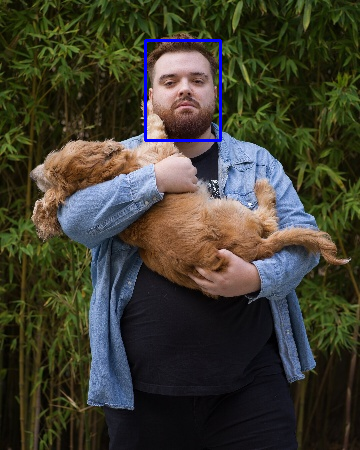

In [13]:
#ground-truth bounding boxes in image dataset
#filename = "img5.jpg"
img = cv2.imread("img5.jpg")
#img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)
cv2.rectangle(img,(145, 40),(220, 140),(255,0,0),2)
cv2_imshow(img)
#cv2.imwrite(filename,img)

In [14]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [15]:
# define the `Detection` object
Detection = namedtuple("Detection", ["image_path", "gt"])

In [16]:
# define the list of example detections
examples = [
	Detection("img1.jpg", [138, 165, 190, 223]),
	Detection("img2.jpg", [365, 80, 470, 210]),
	Detection("img3.jpg", [87, 38, 165, 117]),
	Detection("img4.jpg", [231, 35, 272, 85]),
	Detection("img5.jpg", [155, 60, 213, 125])]

img1.jpg: 0.8048


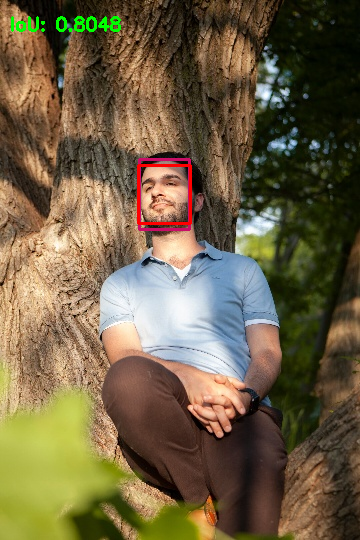

img2.jpg: 0.7679


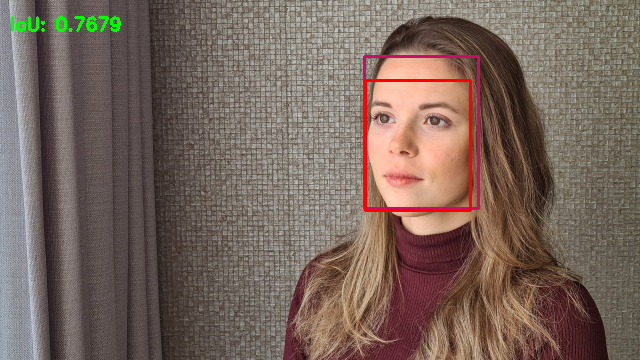

img3.jpg: 0.7268


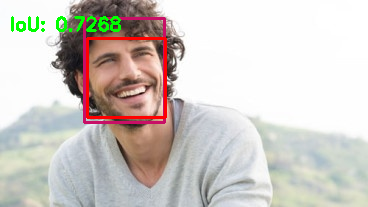

img4.jpg: 0.7560


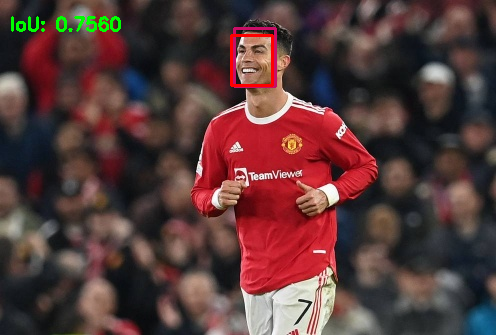

img5.jpg: 0.8849


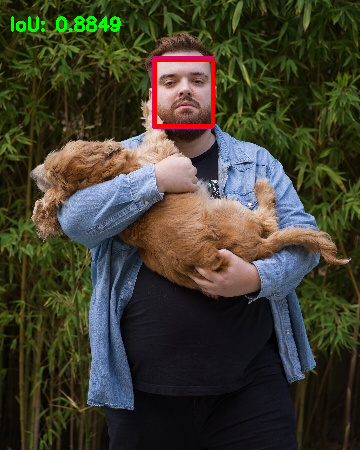

In [17]:
# loop over the example detections
for detection in examples:
	# load the image
	image = cv2.imread(detection.image_path)
	# draw the ground-truth bounding box along with the predicted
	# bounding box
	detections, width_ratio, height_ratio = darknet_helper(image, width, height)
  # draw face bounding box on image
	for label, confidence, bbox in detections:
		left, top, right, bottom = bbox2points(bbox)
		left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
		cv2.rectangle(image, (left, top), (right, bottom), class_colors[label], 2)
		cv2.rectangle(image, tuple(detection.gt[:2]), 
			tuple(detection.gt[2:]), (0, 0, 255), 2)
	# compute the intersection over union and display it
	iou = bb_intersection_over_union(detection.gt, [left,top,right,bottom])
	cv2.putText(image, "IoU: {:.4f}".format(iou), (10, 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
	print("{}: {:.4f}".format(detection.image_path, iou))
	# show the output image
	cv2_imshow(image)
	cv2.waitKey(0)
 

# Using Webcam

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)
    # get face region coordinates
    rects = detector(gray, 0)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    # get face for overlay
    for rect in rects:
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        leftEye = shape[lStart:lEnd]
        rightEye = shape[rStart:rEnd]
        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)

        ear = (leftEAR + rightEAR) / 2.0

        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
      
        bbox_array = cv2.drawContours(bbox_array, [leftEyeHull], -1, (0, 255, 0), 1)
        bbox_array = cv2.drawContours(bbox_array, [rightEyeHull], -1, (0, 255, 0), 1)   

    # Reshape image
    img = frame.copy()
    img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192,192)
    input_image = tf.cast(img, dtype=tf.float32)

    # Setup input and output 
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Make predictions 
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    
    # Rendering 
    bbox_array = draw_connections(bbox_array, keypoints_with_scores, EDGES, 0.4)
    bbox_array = draw_keypoints(bbox_array, keypoints_with_scores, 0.4)

    # draw the computed eye aspect ratio on the frame to help
    # with debugging and setting the correct eye aspect ratio
    # thresholds and frame counters
    #cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),
    #cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>